In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True

In [49]:
import requests
import pandas as pd

# Define the URL for the API
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"

# Define the SQL query to retrieve the required data
query = """
SELECT 
    pl_name, 
    hostname, 
    pl_orbsmax, 
    pl_orbsmaxerr1, 
    pl_orbsmaxerr2, 
    pl_rade,
    pl_radeerr1,
    pl_radeerr2,
    pl_bmasse, 
    pl_bmasseerr1, 
    pl_bmasseerr2, 
    sy_pnum, 
    pl_orbeccen, 
    pl_orbeccenerr1, 
    pl_orbeccenerr2, 
    pl_orbincl, 
    pl_orbinclerr1, 
    pl_orbinclerr2
FROM ps
WHERE 
    default_flag = 1 AND
    sy_pnum > 1
"""

# Define the parameters for the request
params = {
    "query": query,
    "format": "json",
}

# Make the request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data)
    
    # Display the DataFrame
    # print(df)
else:
    print(f"Error: {response.status_code}")

Fill in the missing values in df

In [13]:
# select rows where the pl_orbeccen is nan
eccnan_index = df[df['pl_orbeccen'].isnull()].index
df.loc[eccnan_index, 'pl_orbeccen'] = 0.63 * df.loc[eccnan_index, 'sy_pnum']**(-1.02)
df.loc[eccnan_index, 'pl_orbeccenerr1'] = 0.0
df.loc[eccnan_index, 'pl_orbeccenerr2'] = 0.0

In [14]:
from spright import RMRelation
rmr = RMRelation()

plmassnan_index = df[df['pl_bmasse'].isnull() & (df['pl_rade'] > 0.5) & (df['pl_rade'] < 6.0) & (~df['pl_radeerr1'].isnull() & ~df['pl_radeerr2'].isnull())].index

In [15]:
df[df['pl_bmasse'].isnull()]

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2
9,TOI-2096 c,TOI-2096,0.0400,0.0020,-0.0020,1.914,0.095,-0.095,NaN,NaN,NaN,2,0.100000,0.17,-0.06,89.56,0.26,-0.23
12,GJ 667 C b,GJ 667 C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0.200000,0.10,-0.10,NaN,NaN,NaN
17,Kepler-370 c,Kepler-370,0.1400,NaN,NaN,1.910,0.890,-0.890,NaN,NaN,NaN,2,0.310663,0.00,0.00,NaN,NaN,NaN
18,Kepler-400 b,Kepler-400,0.0870,NaN,NaN,1.650,0.300,-0.300,NaN,NaN,NaN,2,0.310663,0.00,0.00,NaN,NaN,NaN
19,Kepler-221 b,Kepler-221,0.0370,NaN,NaN,1.710,0.170,-0.170,NaN,NaN,NaN,4,0.153193,0.00,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,K2-368 b,K2-368,NaN,NaN,NaN,1.332,0.107,-0.100,NaN,NaN,NaN,3,0.205436,0.00,0.00,NaN,NaN,NaN
2390,K2-275 b,K2-275,0.0277,0.0141,-0.0082,2.340,0.250,-0.270,NaN,NaN,NaN,2,0.310663,0.00,0.00,NaN,NaN,NaN
2391,Kepler-2000 c,Kepler-2000,0.1228,NaN,NaN,1.570,0.060,-0.100,NaN,NaN,NaN,2,0.000000,NaN,NaN,89.82,NaN,NaN
2392,Kepler-1996 c,Kepler-1996,0.3608,NaN,NaN,2.810,0.200,-0.080,NaN,NaN,NaN,2,0.000000,NaN,NaN,89.19,NaN,NaN


In [16]:
for n, idx in enumerate(plmassnan_index):
    if n % 100 == 0:
        print(idx)
    mds = rmr.predict_mass(radius=(df.loc[idx, 'pl_rade'], 0.5 * (df.loc[idx, 'pl_radeerr1'] - df.loc[idx, 'pl_radeerr2'])))
    q16, q50, q84 = np.percentile(mds.samples, [16, 50, 84])
    df.loc[idx, 'pl_bmasse'] = q50
    df.loc[idx, 'pl_bmasseerr1'] = q84 - q50
    df.loc[idx, 'pl_bmasseerr2'] = q16 - q50

9
456
793
1122
1310
1446
1709
1821
1945
2050
2155
2265
2379


In [ ]:
# get rid of columns with rade
df = df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"])

In [33]:
# if the inclination is nan, set it to 90
inclnan_index = df[df['pl_orbincl'].isnull()].index
df.loc[inclnan_index, 'pl_orbincl'] = 90.0
df.loc[inclnan_index, 'pl_orbinclerr1'] = 0.0
df.loc[inclnan_index, 'pl_orbinclerr2'] = 0.0

In [51]:
df.loc[inclnan_index]

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2
0,BD-08 2823 c,BD-08 2823,0.6800,0.0200,-0.0200,NaN,NaN,NaN,104.0,10.0,-10.0,2,0.19,0.09,-0.09,NaN,NaN,NaN
1,HR 8799 c,HR 8799,38.0000,NaN,NaN,13.000,1.000,0.000,3000.0,1000.0,-1000.0,4,NaN,NaN,NaN,NaN,NaN,NaN
10,HIP 5158 b,HIP 5158,0.8900,NaN,NaN,NaN,NaN,NaN,451.0,NaN,NaN,2,0.52,0.08,-0.08,NaN,NaN,NaN
11,Kepler-24 c,Kepler-24,0.1060,NaN,NaN,2.800,NaN,NaN,508.5,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
12,GJ 667 C b,GJ 667 C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0.20,0.10,-0.10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385,K2-381 b,K2-381,NaN,NaN,NaN,1.075,0.142,-0.104,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
2386,EPIC 206317286 c,EPIC 206317286,NaN,NaN,NaN,2.094,0.176,-0.160,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
2387,K2-188 c,K2-188,0.0785,0.0008,-0.0008,2.830,0.150,-0.150,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
2388,K2-368 b,K2-368,NaN,NaN,NaN,1.332,0.107,-0.100,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
rm_hostnames = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # if df_host contains NaN values, save hostname to a list
    if df_host.isnull().values.any():
        # print(df_host)
        rm_hostnames.append(hostname)

# len(rm_hostnames)
df_clean = df[~df["hostname"].isin(rm_hostnames)]

In [35]:
df_clean

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2
0,BD-08 2823 c,BD-08 2823,0.68000,0.02000,-0.02000,104.000000,10.000000,-10.000000,2,0.190000,0.09,-0.090,90.000,0.000,0.00
6,HD 23472 d,HD 23472,0.04298,0.00063,-0.00065,0.550000,0.210000,-0.200000,5,0.070000,0.05,-0.047,87.950,1.200,-0.87
9,TOI-2096 c,TOI-2096,0.04000,0.00200,-0.00200,4.676337,3.407188,-1.141092,2,0.100000,0.17,-0.060,89.560,0.260,-0.23
41,HD 207832 c,HD 207832,2.11200,0.08700,-0.04500,232.015900,57.209400,-15.891500,2,0.270000,0.22,-0.100,90.000,0.000,0.00
42,K2-133 e,K2-133,0.13460,0.00110,-0.00110,4.323977,2.503299,-1.510865,4,0.153193,0.00,0.000,89.164,0.012,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,K2-239 d,K2-239,0.06850,0.00120,-0.00120,1.236056,0.476834,-0.350276,3,0.205436,0.00,0.000,89.430,0.380,-0.45
2359,EPIC 249893012 d,EPIC 249893012,0.22000,0.02000,-0.04000,10.180000,2.460000,-2.420000,3,0.150000,0.21,-0.110,89.470,0.360,-0.50
2365,K2-240 b,K2-240,0.05130,0.00090,-0.00090,5.082077,2.337820,-1.346073,2,0.310663,0.00,0.000,89.260,0.510,-0.64
2387,K2-188 c,K2-188,0.07850,0.00080,-0.00080,8.840347,2.393303,-2.060177,2,0.310663,0.00,0.000,90.000,0.000,0.00


In [36]:
df_clean["hostname"].unique().size

274

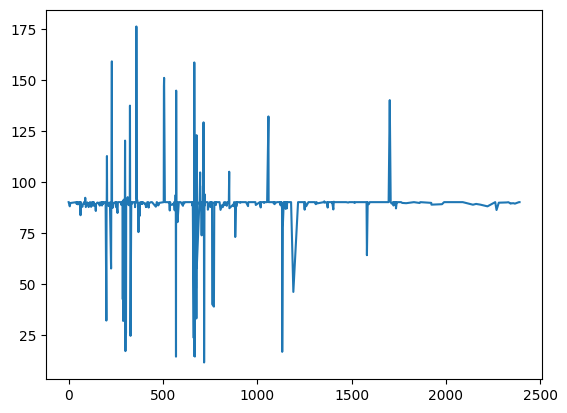

In [37]:
plt.plot(df_clean["pl_orbincl"])

In [38]:
# sort the DataFrame by the hostname
df_clean = df_clean.sort_values(by="hostname")

In [39]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    df_clean.loc[df_host.index, "pl_relincl"] = \
        df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
    
    df_clean.loc[df_host.index, "pl_relinclerr1"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
    
    df_clean.loc[df_host.index, "pl_relinclerr2"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)

In [40]:
df_clean

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_relincl,pl_relinclerr1,pl_relinclerr2
715,HD 145675 c,14 Her,11.924000,1.296000,-1.153000,1597.08775,277.46420,-339.12291,2,0.3930,0.0450,-0.0480,129.097,6.255,-29.051,15.555,8.862893,29.231228
570,14 Her b,14 Her,2.774000,0.109000,-0.120000,2559.47216,518.69596,-280.64248,2,0.3730,0.0080,-0.0060,144.652,6.279,-3.241,0.000,8.879847,4.583466
1612,24 Sex b,24 Sex,1.333000,0.004000,-0.009000,632.46000,82.63000,-120.77000,2,0.0900,0.1400,-0.0600,90.000,0.000,0.000,0.000,0.000000,0.000000
1605,24 Sex c,24 Sex,2.080000,0.050000,-0.020000,273.32000,111.24000,-69.92000,2,0.2900,0.1600,-0.0900,90.000,0.000,0.000,0.000,0.000000,0.000000
1104,47 UMa b,47 UMa,2.100000,0.020000,-0.020000,804.08000,22.25000,-19.07000,3,0.0320,0.0140,-0.0140,90.000,0.000,0.000,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,tau Cet e,tau Cet,0.538000,0.060000,-0.060000,3.93000,0.83000,-0.64000,4,0.1800,0.1800,-0.1400,90.000,0.000,0.000,0.000,0.000000,0.000000
1639,tau Cet f,tau Cet,1.334000,0.017000,-0.044000,3.93000,1.05000,-1.37000,4,0.1600,0.0700,-0.1600,90.000,0.000,0.000,0.000,0.000000,0.000000
1172,ups And b,ups And,0.059222,0.000000,-0.000000,218.53100,1.39839,-1.39839,3,0.0215,0.0007,-0.0007,90.000,0.000,0.000,0.000,0.000000,0.000000
1171,ups And d,ups And,2.513290,0.000750,-0.000750,1313.22000,9.21668,-9.21668,3,0.2987,0.0072,-0.0072,90.000,0.000,0.000,0.000,0.000000,0.000000


In [41]:
def amd(m: np.array, e: np.array, i: np.array, a: np.array) -> np.array:
    return m * np.sqrt(a) * (1 - np.sqrt(1 - e**2) * np.cos(np.deg2rad(i)))

def namd(amd: np.array, m: np.array, a: np.array) -> float:
    return np.sum(amd) / np.sum(m * np.sqrt(a))

In [42]:
for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

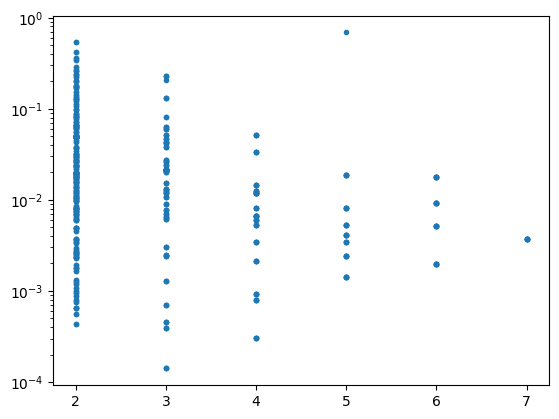

In [43]:
plt.plot(df_clean["sy_pnum"], df_clean["namd"], '.')
plt.yscale("log")

In [44]:
df_clean.hostname.unique()

array(['14 Her', '24 Sex', '47 UMa', '55 Cnc', '61 Vir', '75 Cet',
       'BD-08 2823', 'BD-11 4672', 'BD-210397', 'CoRoT-20',
       'EPIC 212737443', 'EPIC 249893012', 'G 264-012', 'GJ 1002',
       'GJ 1148', 'GJ 15 A', 'GJ 163', 'GJ 180', 'GJ 2030', 'GJ 229',
       'GJ 273', 'GJ 3138', 'GJ 317', 'GJ 328', 'GJ 3293', 'GJ 3323',
       'GJ 3512', 'GJ 357', 'GJ 411', 'GJ 414 A', 'GJ 433', 'GJ 581',
       'GJ 676 A', 'GJ 682', 'GJ 687', 'GJ 806', 'GJ 849', 'GJ 9827',
       'HAT-P-11', 'HAT-P-44', 'HD 10180', 'HD 104067', 'HD 105618',
       'HD 106315', 'HD 107148', 'HD 108236', 'HD 108874', 'HD 109271',
       'HD 110113', 'HD 111232', 'HD 113337', 'HD 113538', 'HD 114783',
       'HD 11506', 'HD 115404 A', 'HD 11964', 'HD 12235', 'HD 125612',
       'HD 12661', 'HD 133131 A', 'HD 133131 B', 'HD 134060', 'HD 134606',
       'HD 134987', 'HD 13808', 'HD 13908', 'HD 140901', 'HD 141399',
       'HD 142', 'HD 147018', 'HD 147873', 'HD 148164', 'HD 151450',
       'HD 15337', 'HD 15355

In [45]:
def compute_namd(userid: str, df: pd.DataFrame, Npt: int, do_plot: bool = True, seed: int = 42):

    np.random.seed(seed)

    user_df = df[df["hostname"] == userid]

    pl_df_mcmc_samples = pd.DataFrame(columns=np.array([[f"pl_bmasse_{pl_name}", f"pl_orbsmax_{pl_name}", f"pl_orbeccen_{pl_name}", f"pl_relincl_{pl_name}"] for pl_name in user_df["pl_name"]]).flatten(), index=range(Npt))

    for pl_name in user_df["pl_name"]:
        pl_df = user_df[user_df["pl_name"] == pl_name]
        
        pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_bmasse"],
            scale=0.5 * (pl_df["pl_bmasseerr1"]-pl_df["pl_bmasseerr2"]),
            size=Npt)
        
        pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_orbsmax"],
            scale=0.5 * (pl_df["pl_orbsmaxerr1"]-pl_df["pl_orbsmaxerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_orbeccen"],
            scale=0.5 * (pl_df["pl_orbeccenerr1"]-pl_df["pl_orbeccenerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_relincl"],
            scale=0.5 * (pl_df["pl_orbinclerr1"]-pl_df["pl_orbinclerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"good_idx_{pl_name}"] = (
            (pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] >= 0) & (pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] <= 1) &
            (pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] >= 0) & (pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] <= 180) &
            (pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"] >= 0) &
            (pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] >= 0)
            )
        
        pl_df_mcmc_samples[f"amd_{pl_name}"] = amd(
            pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_relincl_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"])
        
    # keep rows of pl_df_mcmc_samples where good_idx is True for all planets
    pl_df_mcmc_samples = pl_df_mcmc_samples[pl_df_mcmc_samples.filter(like="good_idx").all(axis=1)]

    # for each row, sum the AMDs of all planets and store the result in a new column called "namd_num"
    pl_df_mcmc_samples["namd_num"] = pl_df_mcmc_samples.filter(like="amd").sum(axis=1)

    # for each row, compute the sum of: (mass of each planet * sqrt(semi-major axis of each planet))
    pl_df_mcmc_samples["namd_den"] = np.sum([pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] * np.sqrt(pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"]) for pl_name in user_df["pl_name"]], axis=0)

    # compute the NAMD
    pl_df_mcmc_samples["namd"] = pl_df_mcmc_samples["namd_num"] / pl_df_mcmc_samples["namd_den"]

    if len(pl_df_mcmc_samples) < Npt // 20:

        return {"q16": np.nan, "q50": np.nan, "q84": np.nan, "N": user_df["sy_pnum"].values[0]}

    quantiles = pl_df_mcmc_samples["namd"].quantile([0.16, 0.5, 0.84])
    if do_plot:
        # plt.hist(pl_df_mcmc_samples["namd"], bins=50)
        # use log-spaced bins instead of linear-spaced bins
        plt.hist(pl_df_mcmc_samples["namd"], bins=np.logspace(np.log10(pl_df_mcmc_samples["namd"].min()), np.log10(pl_df_mcmc_samples["namd"].max()), 50))
        plt.vlines(quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
        plt.xscale("log")
        plt.xlabel("NAMD")
        plt.ylabel("Frequency")
        title = f"{userid}: " + f"NAMD = ${quantiles[0.5]:.2f}^{{+{quantiles[0.84]-quantiles[0.5]:.2f}}}_{{-{quantiles[0.5]-quantiles[0.16]:.2f}}}$"
        plt.title(title)
        plt.show()

    return {"q16": quantiles[0.16], "q50": quantiles[0.5], "q84": quantiles[0.84], "N": user_df["sy_pnum"].values[0]}

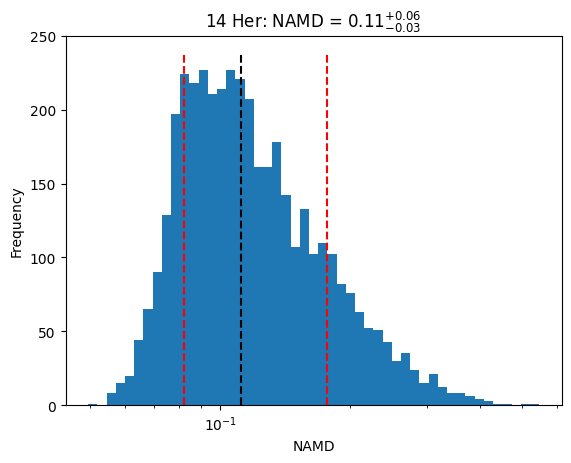

{'q16': 0.08215581947192044,
 'q50': 0.11180422488043931,
 'q84': 0.17652158997486092,
 'N': 2}

In [46]:
userid = "14 Her"
Npt = 10000

compute_namd(userid, df_clean, Npt)

In [52]:
results = {}
nsy = len(df_clean.hostname.unique())
q50 = np.zeros(nsy)
multiplicity = np.zeros(nsy)

for k, name in enumerate(df_clean.hostname.unique()):
    results[name] = compute_namd(name, df_clean, Npt=int(1e5), do_plot=False)
    q50[k] = results[name]["q50"]
    multiplicity[k] = results[name]["N"]
    if multiplicity[k] == 5:
        print(name, results[name])

55 Cnc {'q16': 0.005784225710763498, 'q50': 0.008063494899962265, 'q84': 0.010716011829643194, 'N': 5}
HD 108236 {'q16': 0.0011614212551595256, 'q50': 0.002019047063121227, 'q84': 0.003184050041740592, 'N': 5}
HD 134606 {'q16': 0.0020313422489293704, 'q50': 0.004642421202597075, 'q84': 0.008997033003691885, 'N': 5}
HD 20781 {'q16': 0.0025940580049261175, 'q50': 0.004891708544040902, 'q84': 0.008216320458500714, 'N': 5}
HD 20782 {'q16': 0.6847494615432819, 'q50': 0.687741823934058, 'q84': 0.6907895145903863, 'N': 5}
HD 23472 {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
HD 40307 {'q16': 0.009358928615021486, 'q50': 0.028991681527318004, 'q84': 0.08398916652354854, 'N': 5}
Kepler-186 {'q16': 0.004898339836537446, 'q50': 0.005733939615996039, 'q84': 0.006883289190332125, 'N': 5}


KeyboardInterrupt: 

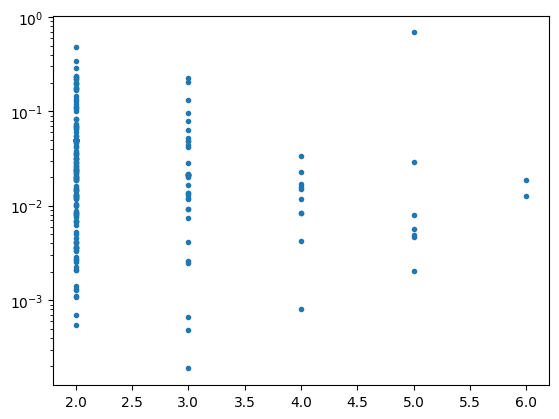

In [48]:
plt.semilogy(multiplicity, q50, '.')